In [1]:
%%capture state
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np
import gc

from models.neural_network import NeuralNetwork
from models.cnn import CNN

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    for i in range(matrix.shape[0]):
        matrix[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix

In [3]:
input_shape = (28,28,1)
num_classes = 10
eps=0.3


In [4]:
#Load model from disk
model_name = 'MNIST'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist')
print (model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 20
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

3330314
Loaded model from disk


In [5]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [6]:
num_test_samples_per_class = 10
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy', eps=eps)
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=eps)
bim_a_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=10, eps=eps)
bim_b_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=10, eps=eps)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF')
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [7]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [8]:
fgsm_guides = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_guides = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_guides = model.model.predict(bim_a_data.reshape(-1,*input_shape))

#Whitebox CW Attack
#First get guide images
guide_indices_fgsm = list()
guide_indices_bim_a = list()
guide_indices_bim_b = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for i in range(num_test_samples):
    label_fgsm = np.argmax(fgsm_guides[i])
    label_bim_a = np.argmax(bim_a_guides[i])
    label_bim_b = np.argmax(bim_b_guides[i])
   
    #Get a test point with the target label
    guide_imgs_indices_fgsm = np.where(model.train_labels[:,label_fgsm] == 1)[0]
    guide_imgs_indices_bim_a = np.where(model.train_labels[:,label_bim_a] == 1)[0]
    guide_imgs_indices_bim_b = np.where(model.train_labels[:,label_bim_b] == 1)[0]
    #Choose a guide image
    guide_img_idx_fgsm = np.random.choice(guide_imgs_indices_fgsm, 1)[0]
    guide_img_idx_bim_a = np.random.choice(guide_imgs_indices_bim_a, 1)[0]
    guide_img_idx_bim_b = np.random.choice(guide_imgs_indices_bim_b, 1)[0]


    guide_indices_fgsm.append(guide_img_idx_fgsm)
    guide_indices_bim_a.append(guide_img_idx_bim_a)
    guide_indices_bim_b.append(guide_img_idx_bim_b)


#1 Phase Attack
fgsm_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM-WB', eps=eps, x_tar=model.train_data[guide_indices_fgsm], y_tar = model.train_labels[guide_indices_fgsm])
bim_a_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='BIM-A-WB', eps=eps, x_tar=model.train_data[guide_indices_bim_a], y_tar = model.train_labels[guide_indices_bim_a])
bim_b_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='BIM-B-WB', eps=eps, x_tar=model.train_data[guide_indices_bim_b], y_tar = model.train_labels[guide_indices_bim_b])

In [9]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist')
model.load_model(model_save_path, weights_save_path)  

Loaded model from disk


In [10]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % num_classes
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps, iterations=1000)

#2 Phase Attack
#Phase 1: Generate targeted adversarial images
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False, eps=eps)
#Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(tar_cw_data, y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps, iterations=1000)

In [11]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [12]:
print (model.model.evaluate(reg_data,model.test_labels[test_indices]))
print (model.model.evaluate(noisy_data,model.test_labels[test_indices]))
print (model.model.evaluate(fgsm_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_a_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_b_data,model.test_labels[test_indices]))
print (model.model.evaluate(fgsm_wb_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_a_wb_data,model.test_labels[test_indices]))
print (model.model.evaluate(bim_b_wb_data,model.test_labels[test_indices]))
print (model.model.evaluate(cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(df_data,model.test_labels[test_indices]))
print (model.model.evaluate(jsma_data,model.test_labels[test_indices]))
print (model.model.evaluate(p1_cw_data,model.test_labels[test_indices]))
print (model.model.evaluate(p2_cw_data,model.test_labels[test_indices]))


100/100 [==============================] - 0s 403us/step
[0.030711167617700996, 0.98999999999999999]
100/100 [==============================] - 0s 179us/step
[0.10631154179573059, 0.96999999999999997]
100/100 [==============================] - 0s 183us/step
[5.2217344284057621, 0.050000000000000003]
100/100 [==============================] - 0s 170us/step
[1.9431056976318359, 0.0]
100/100 [==============================] - 0s 174us/step
[14.152681274414062, 0.0]
100/100 [==============================] - 0s 169us/step
[1.9129487037658692, 0.58999999999999997]
100/100 [==============================] - 0s 170us/step
[0.025407314227777533, 0.98999999999999999]
100/100 [==============================] - 0s 174us/step
[2.2663995332550256e-05, 1.0]
100/100 [==============================] - 0s 171us/step
[0.98772099018096926, 0.0]
100/100 [==============================] - 0s 173us/step
[0.85238224506378168, 0.0]
100/100 [==============================] - 0s 175us/step
[1.7402038335800172, 

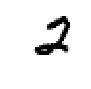

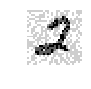

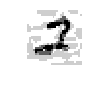

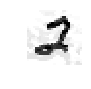

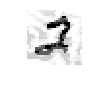

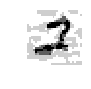

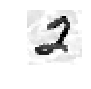

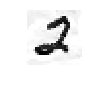

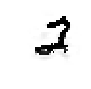

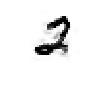

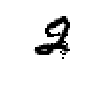

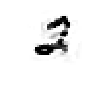

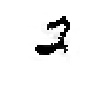

In [13]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(*input_shape))
visualize(noisy_data[x_vis].reshape(*input_shape))
visualize(fgsm_data[x_vis].reshape(*input_shape))
visualize(bim_a_data[x_vis].reshape(*input_shape))
visualize(bim_b_data[x_vis].reshape(*input_shape))
visualize(fgsm_wb_data[x_vis].reshape(*input_shape))
visualize(bim_a_wb_data[x_vis].reshape(*input_shape))
visualize(bim_b_wb_data[x_vis].reshape(*input_shape))
visualize(cw_data[x_vis].reshape(*input_shape))
visualize(df_data[x_vis].reshape(*input_shape))
visualize(jsma_data[x_vis].reshape(*input_shape))
visualize(p1_cw_data[x_vis].reshape(*input_shape))
visualize(p2_cw_data[x_vis].reshape(*input_shape))



In [14]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
noisy_preds = model.model.predict(noisy_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,*input_shape))
fgsm_wb_preds = model.model.predict(fgsm_wb_data.reshape(-1,*input_shape))
bim_a_wb_preds = model.model.predict(bim_a_wb_data.reshape(-1,*input_shape))
bim_b_wb_preds = model.model.predict(bim_a_wb_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,*input_shape))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,*input_shape))


In [15]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_a_labels = np.zeros(bim_a_preds.shape)
bim_a_labels[np.arange(num_test_samples),np.argmax(bim_a_preds, axis=1)] = 1

bim_b_labels = np.zeros(bim_b_preds.shape)
bim_b_labels[np.arange(num_test_samples),np.argmax(bim_b_preds, axis=1)] = 1

fgsm_wb_labels = np.zeros(fgsm_wb_preds.shape)
fgsm_wb_labels[np.arange(num_test_samples),np.argmax(fgsm_wb_preds, axis=1)] = 1

bim_a_wb_labels = np.zeros(bim_a_wb_preds.shape)
bim_a_wb_labels[np.arange(num_test_samples),np.argmax(bim_a_wb_preds, axis=1)] = 1

bim_b_wb_labels = np.zeros(bim_b_wb_preds.shape)
bim_b_wb_labels[np.arange(num_test_samples),np.argmax(bim_b_wb_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1

df_labels = np.zeros(df_preds.shape)
df_labels[np.arange(num_test_samples),np.argmax(df_preds, axis=1)] = 1

jsma_labels = np.zeros(jsma_preds.shape)
jsma_labels[np.arange(num_test_samples),np.argmax(jsma_preds, axis=1)] = 1

p1_cw_labels = np.zeros(p1_cw_preds.shape)
p1_cw_labels[np.arange(num_test_samples),np.argmax(p1_cw_preds, axis=1)] = 1

p2_cw_labels = np.zeros(p2_cw_preds.shape)
p2_cw_labels[np.arange(num_test_samples),np.argmax(p2_cw_preds, axis=1)] = 1

In [16]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_a_preds, axis=1))
print (np.argmax(bim_b_preds, axis=1))
print (np.argmax(fgsm_wb_preds, axis=1))
print (np.argmax(bim_a_wb_preds, axis=1))
print (np.argmax(bim_b_wb_preds, axis=1))
print (np.argmax(cw_preds, axis=1))
print (np.argmax(df_preds, axis=1))
print (np.argmax(jsma_preds, axis=1))
print (np.argmax(p1_cw_preds, axis=1))
print (np.argmax(p2_cw_preds, axis=1))



[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 3]
[0 0 0 0 0 0 0 0 0 0 1 8 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 7]
[2 4 4 8 5 9 8 4 5 2 8 0 2 8 8 8 8 3 3 2 7 7 7 3 7 3 7 2 3 3 9 5 2 5 8 8 5
 9 9 8 9 9 8 2 8 9 9 8 8 7 3 3 3 3 3 3 3 8 3 5 5 0 4 5 4 5 5 6 5 8 8 9 8 3
 2 8 8 8 8 8 0 9 9 3 3 8 9 5 9 8 8 4 5 4 5 8 4 4 7 7]
[2 9 4 8 5 9 8 4 5 4 8 0 7 8 8 2 8 8 3 2 7 7 7 3 7 3 7 8 8 1 9 5 2 5 8 8 5
 9 9 8 9 9 8 2 9 9 9 8 7 7 3 3 3 3 3 3 3 8 3 9 5 0 4 5 4 5 5 5 5 8 5 9 8 3
 2 8 2 5 8 2 0 9 9 9 3 9 9 5 9 6 4 4 5 4 5 8 4 4 8 7]
[2 9 3 8 5 9 8 4 5 4 8 0 3 8 8 8 8 8 3 2 3 3 7 3 7 3 7 8 8 1 9 5 2 5 8 8 5
 9 9 8 9 9 8 2 9 9 9 8 7 7 3 3 3 3 3 3 3 2 3 9 5 0 4 5 4 5 5 5 5 2 5 9 9 3
 2 8 2 5 3 2 0 9 9 9 3 9 9 5 9 6 4

In [17]:

#This is a large network, therefore we need to calculate cos_sim for one type and free memory
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)
#Hack to bypass memory issue, inplace modify
grads_train = normalize(grads_train)

#REG
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_reg_nm = normalize(grads_reg)
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
cos_sim_reg = np.dot(grads_reg_nm, grads_train.T)
del grads_reg_nm, grads_reg
gc.collect()

#NOISY
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_noisy_nm = normalize(grads_noisy)
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
cos_sim_noisy= np.dot(grads_noisy_nm, grads_train.T)
del grads_noisy_nm, grads_noisy
gc.collect()

#FGSM
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_fgsm_nm = normalize(grads_fgsm)
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train.T)
del grads_fgsm_nm, grads_fgsm
gc.collect()

#BIM-A
grads_bim_a = model.get_gradients_wrt_params(bim_a_data, bim_a_labels)
grads_bim_a_nm = normalize(grads_bim_a)
grads_bim_a_norms = np.sqrt(np.dot(grads_bim_a, grads_bim_a.T)).diagonal()
cos_sim_bim_a = np.dot(grads_bim_a_nm, grads_train.T)
del grads_bim_a_nm, grads_bim_a
gc.collect()

#BIM-B
grads_bim_b = model.get_gradients_wrt_params(bim_b_data, bim_b_labels)
grads_bim_b_nm = normalize(grads_bim_b)
grads_bim_b_norms = np.sqrt(np.dot(grads_bim_b, grads_bim_b.T)).diagonal()
cos_sim_bim_b = np.dot(grads_bim_b_nm, grads_train.T)
del grads_bim_b_nm, grads_bim_b
gc.collect()

#Whitebox FGSM, BIM
grads_fgsm_wb = model.get_gradients_wrt_params(fgsm_wb_data, fgsm_wb_labels)
grads_fgsm_wb_nm = normalize(grads_fgsm_wb)
grads_fgsm_wb_norms = np.sqrt(np.dot(grads_fgsm_wb, grads_fgsm_wb.T)).diagonal()
cos_sim_fgsm_wb = np.dot(grads_fgsm_wb_nm, grads_train.T)
del grads_fgsm_wb_nm, grads_fgsm_wb
gc.collect()

grads_bim_a_wb = model.get_gradients_wrt_params(bim_a_wb_data, bim_a_wb_labels)
grads_bim_a_wb_nm = normalize(grads_bim_a_wb)
grads_bim_a_wb_norms = np.sqrt(np.dot(grads_bim_a_wb, grads_bim_a_wb.T)).diagonal()
cos_sim_bim_a_wb = np.dot(grads_bim_a_wb_nm, grads_train.T)
del grads_bim_a_wb_nm, grads_bim_a_wb
gc.collect()

grads_bim_b_wb = model.get_gradients_wrt_params(bim_b_wb_data, bim_b_wb_labels)
grads_bim_b_wb_nm = normalize(grads_bim_b_wb)
grads_bim_b_wb_norms = np.sqrt(np.dot(grads_bim_b_wb, grads_bim_b_wb.T)).diagonal()
cos_sim_bim_b_wb = np.dot(grads_bim_b_wb_nm, grads_train.T)
del grads_bim_b_wb_nm, grads_bim_b_wb
gc.collect()

#CW
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)
grads_cw_nm = normalize(grads_cw)
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()
cos_sim_cw = np.dot(grads_cw_nm, grads_train.T)
del grads_cw_nm, grads_cw
gc.collect()

#DF
grads_df = model.get_gradients_wrt_params(df_data, df_labels)
grads_df_nm = normalize(grads_df)
grads_df_norms = np.sqrt(np.dot(grads_df, grads_df.T)).diagonal()
cos_sim_df = np.dot(grads_df_nm, grads_train.T)
del grads_df_nm, grads_df
gc.collect()


#JSMA
grads_jsma = model.get_gradients_wrt_params(jsma_data, jsma_labels)
grads_jsma_nm = normalize(grads_jsma)
grads_jsma_norms = np.sqrt(np.dot(grads_jsma, grads_jsma.T)).diagonal()
cos_sim_jsma = np.dot(grads_jsma_nm, grads_train.T)
del grads_jsma_nm, grads_jsma
gc.collect()

#p1 - CW
grads_p1_cw = model.get_gradients_wrt_params(p1_cw_data, p1_cw_labels)
grads_p1_cw_nm = normalize(grads_p1_cw)
grads_p1_cw_norms = np.sqrt(np.dot(grads_p1_cw, grads_p1_cw.T)).diagonal()
cos_sim_p1_cw = np.dot(grads_p1_cw_nm, grads_train.T)
del grads_p1_cw_nm,grads_p1_cw
gc.collect()

#p2 - CW
grads_p2_cw = model.get_gradients_wrt_params(p2_cw_data, p2_cw_labels)
grads_p2_cw_nm = normalize(grads_p2_cw)
grads_p2_cw_norms = np.sqrt(np.dot(grads_p2_cw, grads_p2_cw.T)).diagonal()
cos_sim_p2_cw = np.dot(grads_p2_cw_nm, grads_train.T)
del grads_p2_cw_nm, grads_p2_cw
gc.collect()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/d

0

In [18]:
#Separate Using Cos Sim
eta = 0.72

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm_wb[i]) > eta:
        count+=1.0
        
print ('FGSM-WB:  %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a_wb[i]) > eta:
        count+=1.0
        
print ('BIM-A-WB:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b_wb[i]) > eta:
        count+=1.0
        
print ('BIM-B-WB:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta:
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta:
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Regular: 0.8500
Noisy:  0.4900
FGSM:  0.1700
BIM-A:  0.0900
BIM-B:  0.2200
FGSM-WB:  0.2100
BIM-A-WB:  0.6400
BIM-B-WB:  0.6600
CW: 0.0400
DF: 0.0200
JSMA: 0.0600
1 Phase CW:  0.3000
2 Phase CW:  0.0300


In [19]:
#Separate using just norm
gamma =1.0000064

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_wb_norms[i] < gamma:
        count+=1.0
        
print ('FGSM-WB:  %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if grads_bim_a_wb_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A-WB:  %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.8300
Noisy:  0.7700
FGSM:  0.9800
BIM-A:  0.9100
BIM-B:  0.9500
FGSM-WB:  0.8600
BIM-A-WB:  0.6900
CW: 0.8700
DF: 0.9500
JSMA: 0.9800
1 Phase CW: 0.8200
2 Phase CW: 0.9200


In [20]:
#Use both cos and norm

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i]) > eta and grads_bim_a_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > eta and grads_bim_b_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm_wb[i]) > eta and grads_fgsm_wb_norms[i] < gamma:
        count+=1.0
        
print ('FGSM-WB:  %.4f' % ( count/num_test_samples))

    
count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a_wb[i]) > eta and grads_bim_a_wb_norms[i] < gamma:
        count+=1.0
        
print ('BIM-A-WB:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b_wb[i]) > eta and grads_bim_b_wb_norms[i] < gamma:
        count+=1.0
        
print ('BIM-B-WB:  %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > eta and grads_df_norms[i] < gamma:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > eta and grads_jsma_norms[i] < gamma:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > eta and grads_p1_cw_norms[i] < gamma:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > eta and grads_p2_cw_norms[i] < gamma:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))


Regular: 0.6800
Noisy:  0.3100
FGSM:  0.1600
BIM-A:  0.0800
BIM-B:  0.1900
FGSM-WB:  0.1100
BIM-A-WB:  0.3700
BIM-B-WB:  0.3900
CW: 0.0300
DF: 0.0200
JSMA: 0.0600
1 Phase CW: 0.1900
2 Phase CW: 0.0100


In [21]:
def avg_l2_distortion(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    l2_dist = 0.0
    for i in range(orig.shape[0]):
        l2_dist+= np.linalg.norm(orig[i] - adv[i])
    return l2_dist/orig.shape[0]

In [22]:
print ('Noisy: %.5f' % (avg_l2_distortion(reg_data, noisy_data)))
print ('FGSM: %.5f' % (avg_l2_distortion(reg_data, fgsm_data)))
print ('BIM-A: %.5f' % (avg_l2_distortion(reg_data, bim_a_data)))
print ('BIM-B: %.5f' % (avg_l2_distortion(reg_data, bim_b_data)))
print ('FGSM-WB: %.5f' % (avg_l2_distortion(reg_data, fgsm_wb_data)))
print ('BIM-A-WB: %.5f' % (avg_l2_distortion(reg_data, bim_a_wb_data)))
print ('BIM-B-WB: %.5f' % (avg_l2_distortion(reg_data, bim_b_wb_data)))
print ('CW: %.5f' % (avg_l2_distortion(reg_data, cw_data)))
print ('DF: %.5f' % (avg_l2_distortion(reg_data, df_data)))
print ('JSMA: %.5f' % (avg_l2_distortion(reg_data, jsma_data)))
print ('P1-CW: %.5f' % (avg_l2_distortion(reg_data, p1_cw_data)))
print ('P2-CW: %.5f' % (avg_l2_distortion(reg_data, p2_cw_data)))

Noisy: 6.12790
FGSM: 5.76757
BIM-A: 2.43369
BIM-B: 4.64559
FGSM-WB: 6.24951
BIM-A-WB: 4.06601
BIM-B-WB: 4.09444
CW: 2.36832
DF: 1.58925
JSMA: 4.78170
P1-CW: 3.03436
P2-CW: 3.20821


In [23]:
count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a[i])> np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm_wb[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('FGSM-WB:  %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_a_wb[i])> np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-A-WB:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim_b_wb[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('BIM-B-WB:  %.4f' % ( count/num_test_samples))


count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_df[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_jsma[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))


count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p1_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('1 Phase CW:  %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_p2_cw[i]) > np.max(cos_sim_reg[i]):
        count+=1.0
        
print ('2 Phase CW:  %.4f' % ( count/num_test_samples))



Noisy:  0.1100
FGSM:  0.0600
BIM-A:  0.0700
BIM-B:  0.1100
FGSM-WB:  0.0500
BIM-A-WB:  0.2700
BIM-B-WB:  0.2100
CW: 0.0400
DF: 0.0500
JSMA: 0.0300
1 Phase CW:  0.1400
2 Phase CW:  0.0300


In [24]:
count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_a_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-A:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_b_norms[i] < grads_reg_norms[i]:
        count+=1.0
        
print ('BIM-B:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_df_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('DF: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_jsma_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('JSMA: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p1_cw_norms[i] <grads_reg_norms[i]:
        count+=1.0
    
print ('1 Phase CW: %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_p2_cw_norms[i] < grads_reg_norms[i]:
        count+=1.0
    
print ('2 Phase CW: %.4f' % ( count/num_test_samples))

Noisy:  0.3600
FGSM:  0.7200
BIM-A:  0.5900
BIM-B:  0.5800
CW: 0.4500
DF: 0.5800
JSMA: 0.6900
1 Phase CW: 0.5200
2 Phase CW: 0.6300
